In [1]:
import os 
import re
import glob 
import math
import pickle
import joblib

import pandas as pd
import numpy as np
from numpy import array
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from IPython.display import display
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler,RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import scipy
from scipy import stats,interpolate
from scipy.stats import skew,kurtosis,describe,variation,shapiro,levene,f_oneway
from scipy.special import kl_div
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

sns.set(font_scale=1.0)
pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
def describex(data):
        data = pd.DataFrame(data)
        stats = data.describe()
        skewness = data.skew()
        kurtosis = data.kurtosis()
        skewness_df = pd.DataFrame({'skewness':skewness}).T
        kurtosis_df = pd.DataFrame({'kurtosis':kurtosis}).T
        Appended_Stats = pd.concat([stats,skewness_df,kurtosis_df],axis=0)
        return Appended_Stats
    
def mse(y,pred):
    return mean_squared_error(y,pred)

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def MAPE(y,pred):
    return np.mean(np.abs((y-pred)/y)*100)    

def SMAPE(y, pred):
    return (np.mean((np.abs(y-pred))/(np.abs(y) + np.abs(pred))))*100

def evaluate_regr(y,pred): # 종합 평가지표 
    mse_val = mse(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    mape_val = np.mean(np.abs((y-pred)/y)*100)
    smape_val = 100 / len(y) * np.sum(np.abs(pred - y) / (np.abs(y) + np.abs(pred)))
    print("MSE:{0:4F},RMSE:{1:4f},MAE:{2:4F},MAPE:{3:4F},SMAPE:{4:4F}".format(mse_val,rmse_val,mae_val,mape_val,smape_val))

#### 1.) 2023& 2024  전체 CSV 파일 업로드 

In [3]:
df1 = pd.read_csv('2023/01_원당.csv').drop(['TimeStamp'],axis=1) # 1.) 원당
df1 = df1[df1.columns.tolist()[:10]+['탄산포충1탑 온도','탄산포충2탑 온도','탄산포충1탑 CaO','탄산포충2탑 CaO']]
df1.drop(['용당관농도','용당관온도'],axis=1,inplace=True)

df2 = pd.read_csv('2023/02_세당공정.csv').drop(['TimeStamp'],axis=1)    # 2.) 세당
df2.drop(['Root.정당.세당공정.MAGMA.MAGMA_MINGLER_TEMP'],axis=1,inplace=True)

df3 = pd.read_csv('2023/04_포충공정.csv')                            # 3.) 포충
df3.drop(['포충3탑 PH','포충3탑 당액온도'],axis=1,inplace=True) # 3탑 정보 X 
df3['TimeStamp'] = pd.to_datetime(df3['TimeStamp'])
df3['Date'] = df3['TimeStamp'].dt.date

print('2023',df1.shape, df2.shape, df3.shape)
df_2023 = pd.concat([df1,df2,df3],axis=1)


####################################################################################################################################
df1 = pd.read_csv('2024/01_원당.csv').drop(['TimeStamp'],axis=1)    # 1.) 원당                               
df1 = df1[df1.columns.tolist()[:10]+['탄산포충1탑 온도','탄산포충2탑 온도','탄산포충1탑 CaO','탄산포충2탑 CaO']]
df1.drop(['용당관농도','용당관온도'],axis=1,inplace=True)

df2 = pd.read_csv('2024/02_세당.csv').drop(['TimeStamp'],axis=1)    # 2.) 세당
df2.drop(['Root.정당.세당공정.MAGMA.MAGMA_MINGLER_TEMP'],axis=1,inplace=True)

df3 = pd.read_csv('2024/03_포충.csv')                               # 3.) 포충
df3.drop(['포충3탑 PH','포충3탑 당액온도'],axis=1,inplace=True) # 3탑 정보 X 
df3['TimeStamp'] = pd.to_datetime(df3['TimeStamp'])
df3['Date'] = df3['TimeStamp'].dt.date

print('2024',df1.shape, df2.shape, df3.shape)
df_2024 = pd.concat([df1,df2,df3],axis=1)

####################################################################################################################################

df1 = pd.read_csv('2024_추가/01_원당.csv').drop(['TimeStamp'],axis=1)    # 1.) 원당
df1 = df1[df1.columns.tolist()[:10]+['탄산포충1탑 온도','탄산포충2탑 온도','탄산포충1탑 CaO','탄산포충2탑 CaO']]
df1.drop(['용당관농도','용당관온도'],axis=1,inplace=True)

df2 = pd.read_csv('2024_추가/02_세당.csv').drop(['TimeStamp'],axis=1)    # 2.) 세당
df2.drop(['Root.정당.세당공정.MAGMA.MAGMA_MINGLER_TEMP'],axis=1,inplace=True)

df3 = pd.read_csv('2024_추가/03_포충.csv')                               # 3.) 포충
df3.drop(['포충3탑 PH','포충3탑 당액온도'],axis=1,inplace=True) # 3탑 정보 X 
df3['TimeStamp'] = pd.to_datetime(df3['TimeStamp'])
df3['Date'] = df3['TimeStamp'].dt.date

print('2024 추가 ',df1.shape, df2.shape, df3.shape)
df_2024_2 = pd.concat([df1,df2,df3],axis=1)

2023 (52417, 12) (52417, 5) (52417, 12)
2024 (26207, 12) (26207, 5) (26207, 12)
2024 추가  (13247, 12) (13247, 5) (13247, 12)


#### 2.) 공정 원리 시차지연 반영 

In [4]:
cols_stage1 = df1.columns.tolist()
cols_stage2 = df2.columns.tolist()
cols_stage3 = df3.columns.tolist()
df_concat = pd.concat([df_2023,df_2024,df_2024_2],axis=0).reset_index(drop=True)

b = pd.DataFrame(df_concat['포충2탑 석회유 유량']/1000/df_concat['포충2탑 ML공급유량']/0.03)
df_concat['포충2탑 석회비'] = np.round(b,2)

#### 세당 --> 포충공정 실제 공정 체류 /흐름 도달 시간 반영 
df_stage1 = df_concat[cols_stage1].shift(10)
df_stage2 = df_concat[cols_stage2].shift(6)  # 용해공정 체류 시간 반영 
df_stage3 = df_concat[cols_stage3 +['포충2탑 석회비']] # 7 포충 체류 시간 누적 반영


df_ML = pd.concat([df_stage1,df_stage2,df_stage3],axis=1).dropna().reset_index(drop=True)
df_ML = df_ML.dropna().reset_index(drop=True) 
df_ML.shape

(82956, 30)

#### 3.) 특정 불필요 공정기간 제거 

In [5]:
#### 1.) ML유량 감소/보수기간 & 원당 보수기간 전체 제거 
df_ML = df_ML[(df_ML['Date'] < datetime.date(2023, 2, 6)) | (df_ML['Date'] > datetime.date(2023, 2, 12))]
df_ML = df_ML[(df_ML['Date']< datetime.date(2023, 9, 1)) | (df_ML['Date']> datetime.date(2023, 10, 31))]
df_ML = df_ML[(df_ML['Date'] < datetime.date(2023, 11, 6)) | (df_ML['Date'] > datetime.date(2023, 11, 17))]
df_ML = df_ML[(df_ML['Date'] < datetime.date(2024, 3, 11)) | (df_ML['Date'] > datetime.date(2024, 3, 16))]

#### 2.)  행 단위 결측 제거
df_ML = df_ML.dropna().reset_index(drop=True) 

#### 3.) 기본 석회유 유량 제거 
df_ML = df_ML.drop(['석회비'],axis=1)
df_ML.shape

(72866, 29)

#### 3.) Target별 데이터 분할 
- ML기반 예측에서는 지정 Target값 먼저 10분뒤로 이동
- DL기반 예측에서는 3차원 배열 형성시 Target값 자동으로 이동하도록 사후 조치 

In [6]:
def split_dataset(ML,method):
    df_ML_Final1 = ML.drop(['TimeStamp','Date','탄산포충2탑 온도','탄산포충2탑 CaO','포충2탑 ML공급유량','포충2탑 석회유 유량','포충2탑 PH'],axis=1)
    df_ML_Final1 = df_ML_Final1.drop(['탄산포충1탑 온도','탄산포충1탑 CaO','포충2탑 석회비'],axis=1)
    
    df_ML_Final2 = ML.drop(['TimeStamp','Date','탄산포충1탑 온도','탄산포충1탑 CaO','포충1탑 ML공급유량','포충1탑 석회유 유량','포충1탑 PH'],axis=1)
    df_ML_Final2 = df_ML_Final2.drop(['탄산포충2탑 온도','탄산포충2탑 CaO'],axis=1)
    
    if method =='ml':
        target = df_ML_Final1['포충1탑 ML공급유량'].shift(-1)
        df_ML_Final1 = df_ML_Final1.drop(['포충1탑 ML공급유량'],axis=1)
        df_ML_Final1 = pd.concat([df_ML_Final1,target],axis=1)
        df_ML_Final1 = df_ML_Final1.dropna().reset_index(drop=True)
        
        target = df_ML_Final2['포충2탑 ML공급유량'].shift(-1)
        df_ML_Final2 = df_ML_Final2.drop(['포충2탑 ML공급유량'],axis=1)
        df_ML_Final2 = pd.concat([df_ML_Final2,target],axis=1)
        df_ML_Final2 = df_ML_Final2.dropna().reset_index(drop=True)
    else:
        target = df_ML_Final1['포충1탑 ML공급유량']
        df_ML_Final1 = df_ML_Final1.drop(['포충1탑 ML공급유량'],axis=1)
        df_ML_Final1 = pd.concat([df_ML_Final1,target],axis=1)
        
        target = df_ML_Final2['포충2탑 ML공급유량']
        df_ML_Final2 = df_ML_Final2.drop(['포충2탑 ML공급유량'],axis=1)
        df_ML_Final2 = pd.concat([df_ML_Final2,target],axis=1)
        
    return df_ML_Final1,df_ML_Final2

In [7]:
ML = df_ML    # --> 최종 ML공급유량 예측 대상 제당공정 데이터 전처리 완료 
method = 'ml' # --> 현재 데이터에서 Y_Target값 따로 1시점 지연 적용 
df_ML_Final1,df_ML_Final2 = split_dataset(ML,method)
df_ML_Final1.shape, df_ML_Final2.shape

((72865, 19), (72865, 20))

In [8]:
df_ML_Final1.head(5)

,원당 Pol (˚Z),원당 I.S (%),원당 Moisture(%),원당 Filtrabillty(%),원당 Ash (%),원당 Color (IU),원당 starch,원당 Alcohol Floc,Root.정당.세당공정.MAGMA.MAGMA_MINGLER_AMP,Root.정당.세당공정.MAGMA.MAGMA_HEATER_TEMP_PV,Root.정당.세당공정.카로리화이어.CARORIFIER_S/T_TEMP,Root.정당.세당공정.MELTER.ML_TEMP_PV,Root.정당.세당공정.MELTER.MELTER_CONTROL_BX,CO2가스농도,CO2가스유량,CO2가스압력,포충1탑 석회유 유량,포충1탑 PH,포충1탑 ML공급유량
0,99.09,0.254,0.293,74.0,0.283,2390.0,59.0,77.8,60.386414,43.934486,91.878532,77.303947,66.556442,9.879126,91.159454,0.519192,981.356018,8.730016,41.985771
1,99.09,0.254,0.293,74.0,0.283,2390.0,59.0,77.8,56.177780,42.165478,92.636414,77.083176,66.640137,9.955312,90.941032,0.519308,979.536560,8.706409,42.022781
2,99.09,0.254,0.293,74.0,0.283,2390.0,59.0,77.8,54.305828,44.074844,92.721207,77.888474,66.558517,9.941677,91.045387,0.518899,977.472534,8.689629,39.013248
3,99.09,0.254,0.293,74.0,0.283,2390.0,59.0,77.8,63.802204,43.746807,92.007339,77.046654,66.718269,9.940840,91.740227,0.518853,916.715393,8.738333,36.985180
4,99.09,0.254,0.293,74.0,0.283,2390.0,59.0,77.8,64.868164,42.557995,91.028252,76.513641,66.224548,9.868645,91.022881,0.518532,862.680054,8.757335,36.864437


In [9]:
df_ML_Final1.columns = ['POL', 'ISS', 'MOIST', 'FRATE', 'ASH', 'CVIU', 'STARCH', 'HAZE',
                       'MAGMA_MINGLER_AMP_value','MAGMA_HEATER_TEMP_PV_value','CARORIFIER_S/T_TEMP_value',
                      'ML_TEMP_PV_value','MELTER_CONTROL_BX_value','CO2_GAS_concentration_value','CO2_GAS_F_value',
                      'CO2_GAS_PRESS_value','SATURATOR1_CALCIUM_F_value','SATURATOR1_PH_PV_value','SATURATOR1_ML_SUPPLY_F_PV_value']

df_ML_Final2.columns = ['POL', 'ISS', 'MOIST', 'FRATE', 'ASH', 'CVIU', 'STARCH', 'HAZE',
                       'MAGMA_MINGLER_AMP_value','MAGMA_HEATER_TEMP_PV_value','CARORIFIER_S/T_TEMP_value',
                      'ML_TEMP_PV_value','MELTER_CONTROL_BX_value','CO2_GAS_concentration_value','CO2_GAS_F_value',
                      'CO2_GAS_PRESS_value','SATURATOR2_CALCIUM_F_value','SATURATOR2_PH_PV_value','SATURATOR2_CARBON_ratio','SATURATOR2_ML_SUPPLY_F_PV_value']

#### 4.) 다변량 통계 특징 분석

In [10]:
print('포충1탑 ML공급유량 분산',df_ML_Final1['SATURATOR1_ML_SUPPLY_F_PV_value'].var())
print('포충1탑 ML공급유량 변동계수',df_ML_Final1['SATURATOR1_ML_SUPPLY_F_PV_value'].std()/df_ML_Final1['SATURATOR1_ML_SUPPLY_F_PV_value'].mean())
print('포충2탑 ML공급유량 분산',df_ML_Final2['SATURATOR2_ML_SUPPLY_F_PV_value'].var())
print('포충2탑 ML공급유량 변동계수',df_ML_Final2['SATURATOR2_ML_SUPPLY_F_PV_value'].std()/df_ML_Final2['SATURATOR2_ML_SUPPLY_F_PV_value'].mean())

포충1탑 ML공급유량 분산 23.01351500485629
포충1탑 ML공급유량 변동계수 0.12869472671649332
포충2탑 ML공급유량 분산 22.46459733756246
포충2탑 ML공급유량 변동계수 0.1275154670968385


In [11]:
col = 'SATURATOR1_ML_SUPPLY_F_PV_value'

rolling_std_series = df_ML_Final1[col].rolling(window=100).std()
mean_rolling_std = rolling_std_series.dropna().mean()
print("100개 단위 구간 표준편차의 평균:", mean_rolling_std)

100개 단위 구간 표준편차의 평균: 3.4728831703772265


In [12]:
col = 'SATURATOR2_ML_SUPPLY_F_PV_value'

rolling_std_series = df_ML_Final2[col].rolling(window=100).std()
mean_rolling_std = rolling_std_series.dropna().mean()
print("100개 단위 구간 표준편차의 평균:", mean_rolling_std)

100개 단위 구간 표준편차의 평균: 3.458313380840593


In [13]:
df_ML_Final1['SATURATOR1_ML_SUPPLY_F_PV_value'].skew(), df_ML_Final1['SATURATOR1_ML_SUPPLY_F_PV_value'].kurtosis()

(-1.4466115060937303, 6.433792438800351)

In [14]:
df_ML_Final2['SATURATOR2_ML_SUPPLY_F_PV_value'].skew(), df_ML_Final2['SATURATOR2_ML_SUPPLY_F_PV_value'].kurtosis()

(-1.5190674274581506, 6.832176930774901)

-1.4466115060937303 6.433792438800351
-1.5190674274581506 6.832176930774901


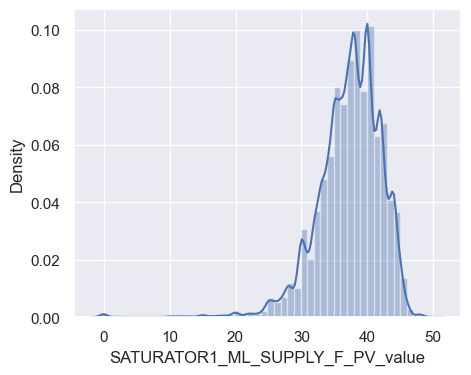

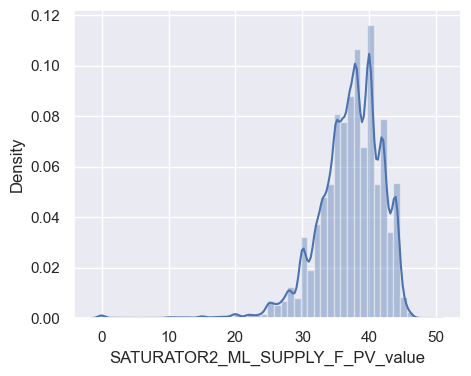

,SATURATOR1_ML_SUPPLY_F_PV_value
SATURATOR1_CALCIUM_F_value,0.778689
SATURATOR1_PH_PV_value,0.395355
MELTER_CONTROL_BX_value,0.295046
MAGMA_MINGLER_AMP_value,0.267047
HAZE,0.177320
CO2_GAS_PRESS_value,0.151253
CARORIFIER_S/T_TEMP_value,0.136078
ASH,0.132881
MOIST,0.092821
POL,0.089531


,SATURATOR2_ML_SUPPLY_F_PV_value
SATURATOR2_CALCIUM_F_value,0.768349
SATURATOR2_PH_PV_value,0.414650
MELTER_CONTROL_BX_value,0.302301
MAGMA_MINGLER_AMP_value,0.277131
HAZE,0.158298
CO2_GAS_PRESS_value,0.152760
CARORIFIER_S/T_TEMP_value,0.136678
ASH,0.120883
POL,0.089223
ML_TEMP_PV_value,0.080656


In [15]:
print(df_ML_Final1['SATURATOR1_ML_SUPPLY_F_PV_value'].skew(),df_ML_Final1['SATURATOR1_ML_SUPPLY_F_PV_value'].kurtosis())
print(df_ML_Final2['SATURATOR2_ML_SUPPLY_F_PV_value'].skew(),df_ML_Final2['SATURATOR2_ML_SUPPLY_F_PV_value'].kurtosis())

sns.set(font_scale=1.0)
plt.figure(figsize=(5,4))
plt.grid(True)
sns.distplot(df_ML_Final1['SATURATOR1_ML_SUPPLY_F_PV_value'])
plt.show()
plt.figure(figsize=(5,4))
sns.distplot(df_ML_Final2['SATURATOR2_ML_SUPPLY_F_PV_value'])
plt.show()

pd.set_option('display.max_rows', None)
display(df_ML_Final1.corr()[['SATURATOR1_ML_SUPPLY_F_PV_value']].sort_values(by='SATURATOR1_ML_SUPPLY_F_PV_value',ascending=False).iloc[1:])
display(df_ML_Final2.corr()[['SATURATOR2_ML_SUPPLY_F_PV_value']].sort_values(by='SATURATOR2_ML_SUPPLY_F_PV_value',ascending=False).iloc[1:])
pd.set_option('display.max_rows', 10)

#### 5.) Ex. 포충1탑 ML공급유량 분석
- Tree모델 기반 Point Regression & Quantile Regression

In [16]:
#### 1.) 마지막 10,000개를 Test용 데이터 / 이전 데이터를 Train 데이터로 구축 ( 시계열 데이터 순차적 학습/검증 분할 적용 )
split = -10000 

#### 2.) 최종 입력 / Target 데이터 정의 
train_data = df_ML_Final1.drop(['POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE'],axis=1).reset_index(drop=True)[0:split]
test_data = df_ML_Final1.drop(['POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE'],axis=1).reset_index(drop=True)[split:]
X_train = train_data.drop('SATURATOR1_ML_SUPPLY_F_PV_value',axis=1,inplace=False)
X_test =  test_data.drop('SATURATOR1_ML_SUPPLY_F_PV_value',axis=1,inplace=False)
X_train = train_data.drop('SATURATOR1_ML_SUPPLY_F_PV_value',axis=1,inplace=False)
X_test =  test_data.drop('SATURATOR1_ML_SUPPLY_F_PV_value',axis=1,inplace=False)
y_train = train_data['SATURATOR1_ML_SUPPLY_F_PV_value']
y_test = test_data['SATURATOR1_ML_SUPPLY_F_PV_value']

#### 3.) 모델 구축 
ml = LGBMRegressor(random_state=2021,verbose=-1)
ml.fit(X_train,y_train) 
#joblib.dump(ml.fit(X_train,y_train),'pkl/ML_BX1_LGBM.pkl')
pred = ml.predict(X_test) 
print(evaluate_regr(pred,y_test))

ml = XGBRegressor(random_state=2021)
ml.fit(X_train,y_train) 
#joblib.dump(ml.fit(X_train,y_train),'pkl/ML_BX1_XGB.pkl')
pred = ml.predict(X_test)
print(evaluate_regr(pred,y_test))

ml = GradientBoostingRegressor(random_state=2021)
ml.fit(X_train,y_train) 
#joblib.dump(ml.fit(X_train,y_train),'pkl/ML_BX1_GBM.pkl')
pred = ml.predict(X_test)  
print(evaluate_regr(pred,y_test))

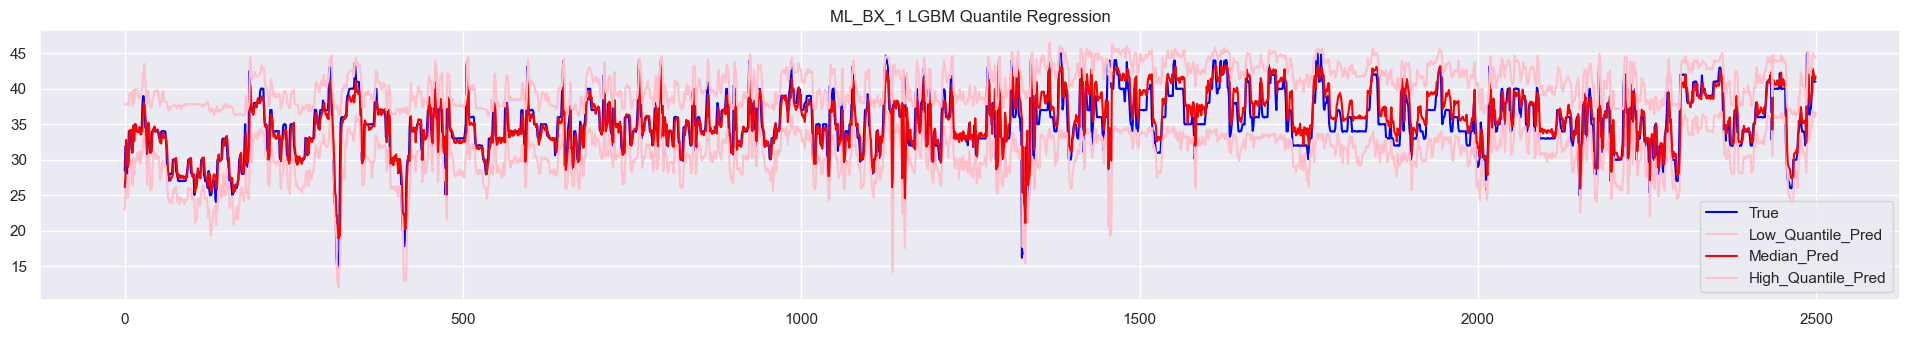

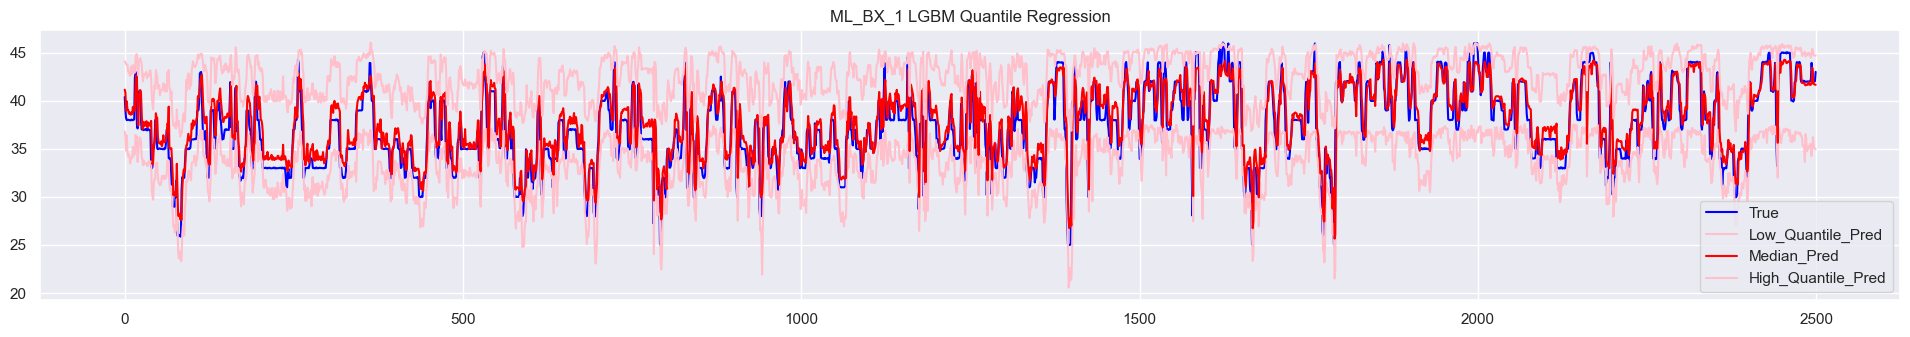

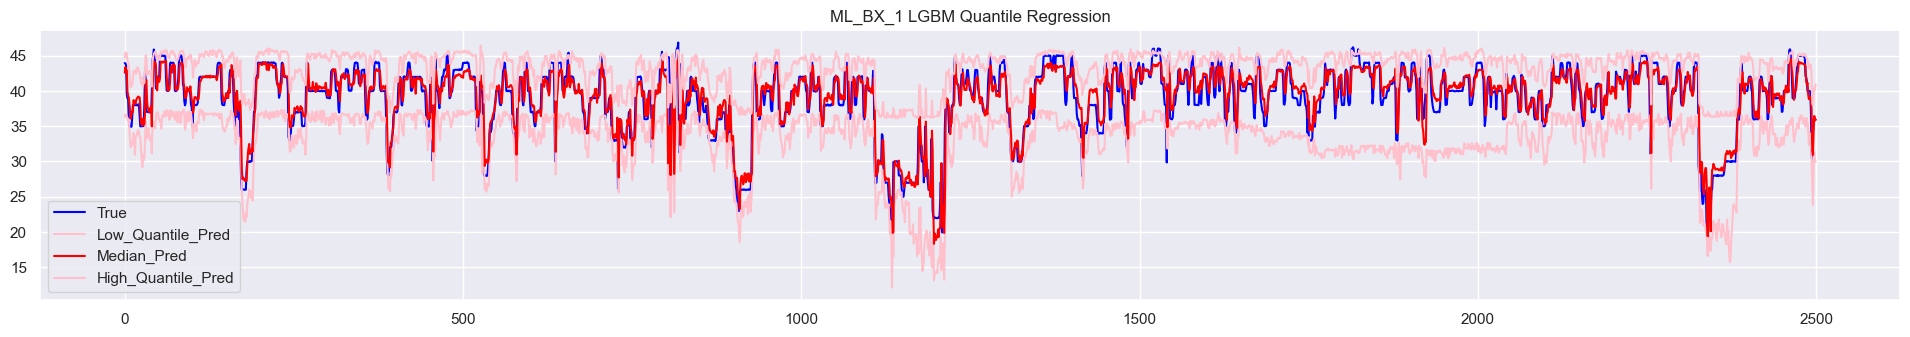

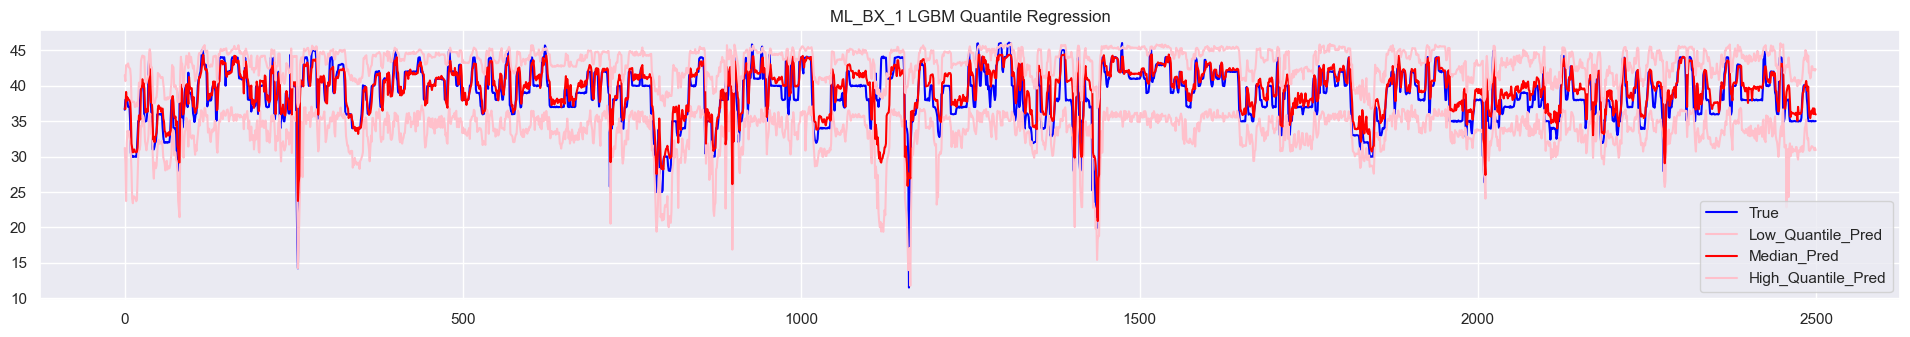

In [17]:
### cv is 12%
quantiles = [0.015,0.5,0.985] # min , mean, max
predictions_lgbm = {}
for q in quantiles:
    lgb_model=LGBMRegressor(objective='quantile',alpha=q,random_state=2021,verbose=-1)
    lgb_model.fit(X_train,y_train)
    #joblib.dump(lgb_model.fit(X_train,y_train),'SamYang_API/pkl/ML_BX1_LGBM_quantile='+str(q)+'.pkl')
    predictions_lgbm[f'LightGBM_Q{int(q*100)}']=lgb_model.predict(X_test)
sns.set(font_scale=1.0)
for i in range(0,len(test_data),2500):
    plt.figure(figsize=(24,3.5))
    plt.title('ML_BX_1 LGBM Quantile Regression')
    plt.plot(y_test.iloc[i:i+2500].reset_index(drop=True),color='blue',label='True')
    plt.plot(pd.DataFrame(predictions_lgbm['LightGBM_Q1']).iloc[i:i+2500].reset_index(drop=True),color='pink',label='Low_Quantile_Pred')
    plt.plot(pd.DataFrame(predictions_lgbm['LightGBM_Q50']).iloc[i:i+2500].reset_index(drop=True),color='red',label='Median_Pred')
    plt.plot(pd.DataFrame(predictions_lgbm['LightGBM_Q98']).iloc[i:i+2500].reset_index(drop=True),color='pink',label='High_Quantile_Pred')
    plt.legend()

#### 6.) Ex. 포충1탑 ML공급유량 분석
- Point / Monte Carlo Dropout Bidirectional GRU  

In [26]:
import tensorflow 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

def make_sequence_dataset(feature, label, window_size): # (Batch Size, Feature 개수,Time Step)
    feature_list = []      # 생성될 feature list
    label_list = []        # 생성될 label list
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
    return np.array(feature_list), np.array(label_list) # 3차원 데이터로 변경 

In [27]:
ML = df_ML # --> 최종 ML공급유량 예측 대상 제당공정 데이터 전처리 완료 
method = 'dl' # --> 현재 데이터에서 Y_Target값 따로 1시점 지연 적용 X 
df_ML_Final1,df_ML_Final2 = split_dataset(ML,method)
df_ML_Final1.shape, df_ML_Final2.shape

((72866, 19), (72866, 20))

In [28]:
df_ML_Final1.columns = ['POL', 'ISS', 'MOIST', 'FRATE', 'ASH', 'CVIU', 'STARCH', 'HAZE',
                       'MAGMA_MINGLER_AMP_value','MAGMA_HEATER_TEMP_PV_value','CARORIFIER_S/T_TEMP_value',
                      'ML_TEMP_PV_value','MELTER_CONTROL_BX_value','CO2_GAS_concentration_value','CO2_GAS_F_value',
                      'CO2_GAS_PRESS_value','SATURATOR1_CALCIUM_F_value','SATURATOR1_PH_PV_value','SATURATOR1_ML_SUPPLY_F_PV_value']

df_ML_Final2.columns = ['POL', 'ISS', 'MOIST', 'FRATE', 'ASH', 'CVIU', 'STARCH', 'HAZE',
                       'MAGMA_MINGLER_AMP_value','MAGMA_HEATER_TEMP_PV_value','CARORIFIER_S/T_TEMP_value',
                      'ML_TEMP_PV_value','MELTER_CONTROL_BX_value','CO2_GAS_concentration_value','CO2_GAS_F_value',
                      'CO2_GAS_PRESS_value','SATURATOR2_CALCIUM_F_value','SATURATOR2_PH_PV_value','SATURATOR2_CARBON_ratio','SATURATOR2_ML_SUPPLY_F_PV_value']

In [29]:
##### 1.) 입력데이터 & Train/Valid/Test 순차적 데이터 분리 & 3차원 배열 데이터에 적용할 Window_Size(TimeStep) 지정
df_dl = df_ML_Final1
df_dl = df_ML_Final1.drop(['POL','ISS','MOIST','FRATE','ASH','CVIU','STARCH','HAZE'],axis=1).reset_index(drop=True)

window_size = 14

train = df_dl.iloc[:61000]             # Train
val = df_dl.iloc[61000:len(df_dl) - 10000 -window_size]         # Valid
test = df_dl.iloc[len(df_dl) - 10000 -window_size:]             # Test 

##### 2.) Train Data 기반 MinMaxScaler로 Valid / Test 정규화 
from sklearn.preprocessing import MinMaxScaler
scale_cols = df_dl.columns.tolist()
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train)

feature_train = pd.DataFrame(scaler.transform(train),columns = train.columns)
label_train = feature_train[['SATURATOR1_ML_SUPPLY_F_PV_value']]

feature_val = pd.DataFrame(scaler.transform(val),columns = val.columns)
label_val = feature_val[['SATURATOR1_ML_SUPPLY_F_PV_value']]

feature_test = pd.DataFrame(scaler.transform(test),columns = test.columns)
label_test = feature_test[['SATURATOR1_ML_SUPPLY_F_PV_value']]

feature_train.drop(['SATURATOR1_ML_SUPPLY_F_PV_value'],axis=1,inplace=True)
feature_val.drop(['SATURATOR1_ML_SUPPLY_F_PV_value'],axis=1,inplace=True)
feature_test.drop(['SATURATOR1_ML_SUPPLY_F_PV_value'],axis=1,inplace=True)

feature_train_np = feature_train.to_numpy() 
label_train_np = label_train.to_numpy()     

feature_val_np = feature_val.to_numpy()
label_val_np = label_val.to_numpy()     

feature_test_np = feature_test.to_numpy() 
label_test_np = label_test.to_numpy()     

#### 3.) DL기반 데이터 전처리 (N x D) --> (B,T,D) 형식으로 변경 
X_train, y_train = make_sequence_dataset(feature_train_np, label_train_np, window_size) 
X_val, y_val = make_sequence_dataset(feature_val_np, label_val_np, window_size) 
X_test, y_test = make_sequence_dataset(feature_test_np, label_test_np, window_size) 

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(60986, 14, 10) (60986, 1)
(1838, 14, 10) (1838, 1)
(10000, 14, 10) (10000, 1)


In [30]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

def mc_dropout(rate):
    return Lambda(lambda x:tf.keras.backend.dropout(x,level=rate))
model = Sequential()
model.add(Bidirectional(GRU(44,input_shape=(X_train.shape[1],X_train.shape[2]),activation='tanh',return_sequences=True)))
model.add(mc_dropout(0.3))  
model.add(Bidirectional(GRU(32, activation='tanh', return_sequences=False)))
model.add(mc_dropout(0.3))  
model.add(Dense(1, activation='tanh')) 
model.compile(loss='mean_squared_error', optimizer='adam', metrics='mae')
early_stopping = EarlyStopping(patience=5,restore_best_weights=True)
model.fit(X_train,y_train,validation_data=(X_val, y_val),epochs=200,batch_size=53,callbacks=[early_stopping])
model.summary()

from tqdm import tqdm
def monte_carlo_predictions(model,X_input,n_simulations=100):
    preds = np.array([model(X_input, training=True) for _ in tqdm(range(n_simulations), desc="Running MC Dropout")])
    min_prediction = preds.min(axis=0)
    prediction_copies_array = np.repeat(min_prediction,X_train.shape[2]+1, axis=-1)
    pred_min = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(min_prediction),X_train.shape[2]+1)))[:,-1] 
    mean_prediction = preds.mean(axis=0)
    prediction_copies_array = np.repeat(mean_prediction,X_train.shape[2]+1, axis=-1)
    pred_mean = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(mean_prediction),X_train.shape[2]+1)))[:,-1] 
    max_prediction = preds.max(axis=0)
    prediction_copies_array = np.repeat(max_prediction,X_train.shape[2]+1, axis=-1)
    pred_max = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(max_prediction),X_train.shape[2]+1)))[:,-1] 
    uncertainty = preds.std(axis=0)
    prediction_copies_array = np.repeat(mean_prediction+uncertainty,X_train.shape[2]+1, axis=-1)
    pred_uncertainty = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(uncertainty),X_train.shape[2]+1)))[:,-1] - pred_mean 
    return pred_min, pred_mean, pred_uncertainty ,pred_max

n_simulations = 100
pred_min, pred_mean, pred_uncertainty ,pred_max = monte_carlo_predictions(model,X_test,n_simulations)
pred_upper = pred_mean + 3.5*pred_uncertainty
pred_lower = pred_mean - 3.5*pred_uncertainty
true = test.iloc[window_size:]['SATURATOR1_ML_SUPPLY_F_PV_value'].reset_index(drop=True)
print(evaluate_regr(pred_mean,true))

Epoch 1/200
1151/1151 [==============================] - 10s 7ms/step - loss: 0.0232 - mae: 0.1106 - val_loss: 0.0097 - val_mae: 0.0744
Epoch 2/200
1151/1151 [==============================] - 7s 6ms/step - loss: 0.0144 - mae: 0.0892 - val_loss: 0.0081 - val_mae: 0.0668
Epoch 3/200
1151/1151 [==============================] - 7s 6ms/step - loss: 0.0134 - mae: 0.0851 - val_loss: 0.0084 - val_mae: 0.0676
Epoch 4/200
1151/1151 [==============================] - 7s 6ms/step - loss: 0.0125 - mae: 0.0823 - val_loss: 0.0076 - val_mae: 0.0634
Epoch 5/200
1151/1151 [==============================] - 7s 6ms/step - loss: 0.0116 - mae: 0.0792 - val_loss: 0.0127 - val_mae: 0.0911
Epoch 6/200
1151/1151 [==============================] - 7s 6ms/step - loss: 0.0109 - mae: 0.0761 - val_loss: 0.0085 - val_mae: 0.0711
Epoch 7/200
1151/1151 [==============================] - 7s 6ms/step - loss: 0.0100 - mae: 0.0716 - val_loss: 0.0094 - val_mae: 0.0749
Epoch 8/200
1151/1151 [==============================]

Running MC Dropout: 100%|████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]

MSE:4.889298,RMSE:2.211176,MAE:1.542498,MAPE:4.217567,SMAPE:2.118657
None


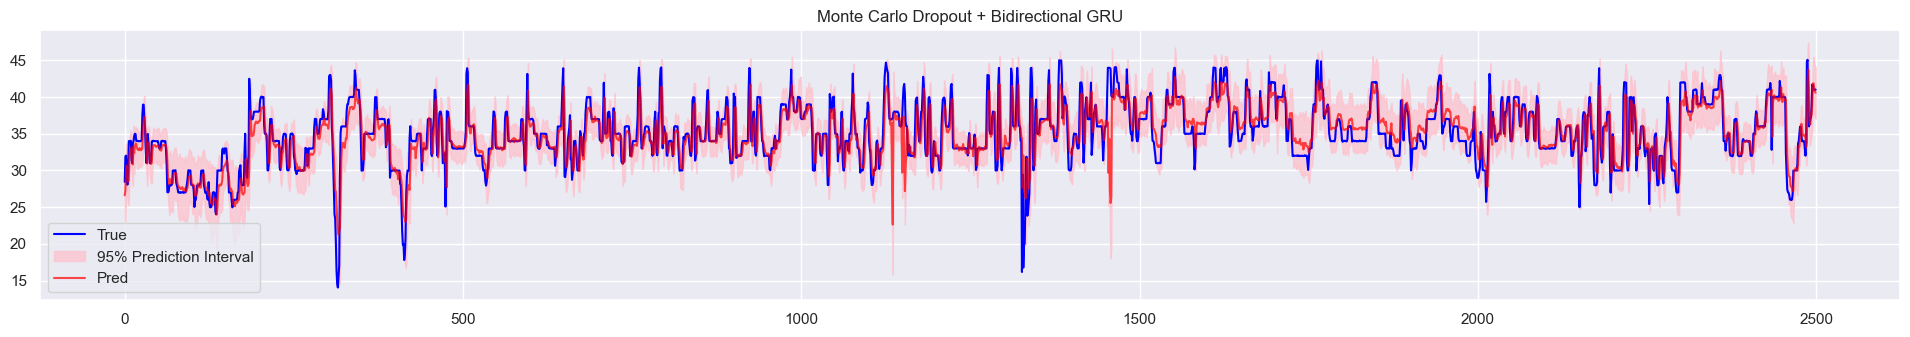

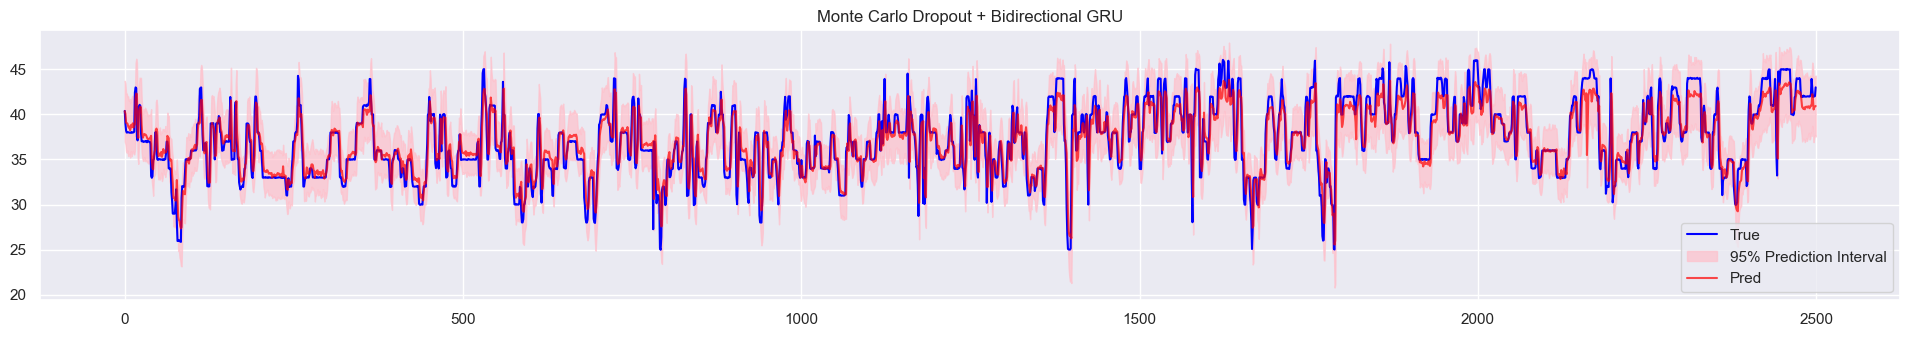

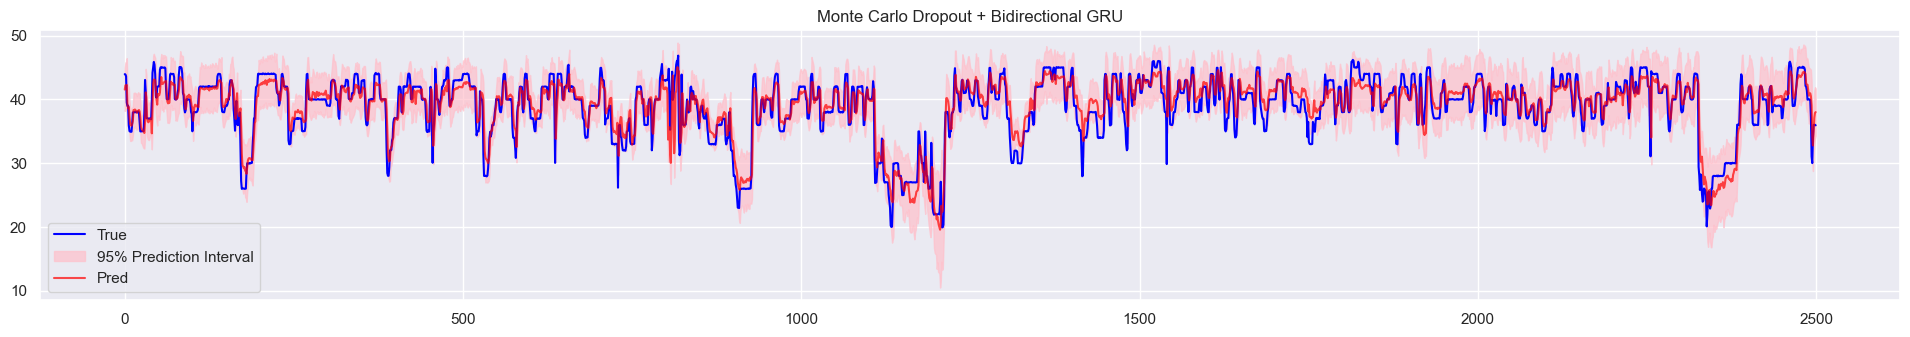

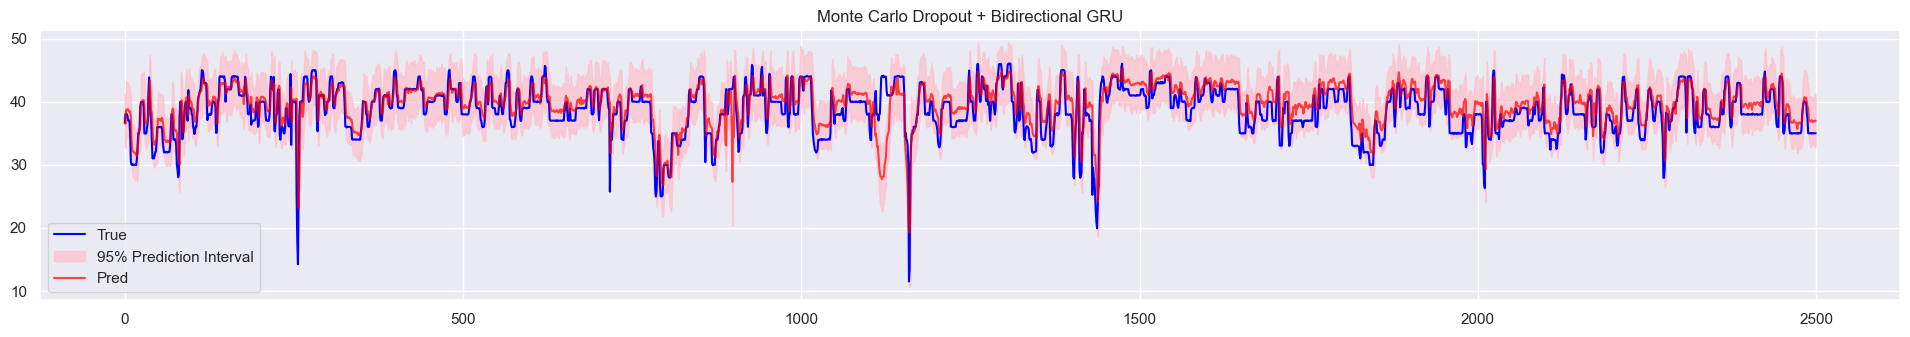

In [31]:
for i in range(0,y_test.shape[0],2500):
    plt.figure(figsize=(24,3.5))
    plt.title('Monte Carlo Dropout + Bidirectional GRU')
    plt.plot(true.iloc[i:i+2500].reset_index(drop=True),color='blue',label='True')
    plt.fill_between(pd.DataFrame(y_test)[0].iloc[i:i+2500].reset_index(drop=True).index, pd.DataFrame(pred_lower).iloc[i:i+2500][0].reset_index(drop=True), pd.DataFrame(pred_upper).iloc[i:i+2500][0].reset_index(drop=True), alpha=.7, color='pink',label='95% Prediction Interval')
    plt.plot(pd.DataFrame(pred_mean).iloc[i:i+2500].reset_index(drop=True),color='red',label='Pred',alpha=.7)
    plt.legend()